In [1]:
from itertools import chain
from typing import Tuple, Set
from pathlib import Path
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib.colors import rgb2hex
import seaborn as sns
%matplotlib inline

In [2]:
cmap = cm.get_cmap("tab20", 20)
PALETTE = [rgb2hex(cmap(i)) for i in range(cmap.N)]
ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]
DELIM = ","
PAIR_IDX = ("sample1", "sample2")

In [3]:
class AsymmetrixMatrixError(Exception):
    pass


def load_matrix(fpath, delim: str = DELIM, name: str = "") -> pd.Series:
    matrix = []
    with open(fpath) as instream:
        header = next(instream).rstrip()
        names = np.array(header.split(delim)[1:])
        idx = np.argsort(names)
        sorted_names = names[idx]
        for row in map(str.rstrip, instream):
            # sort row according to the name sorting
            sorted_row = np.array(row.split(delim)[1:], dtype=int)[idx]
            matrix.append(sorted_row)

    sorted_matrix = np.array(matrix)[idx]
    n_samples = len(sorted_names)
    diagonal_is_zero = all(sorted_matrix[i, i] == 0 for i in range(n_samples))
    if not diagonal_is_zero:
        raise AsymmetrixMatrixError("Distance matrix diagonal is not all zero")

    matrix_is_symmetric = np.allclose(sorted_matrix, sorted_matrix.T)
    if not matrix_is_symmetric:
        raise AsymmetrixMatrixError("Distance matrix is not symmetric")

    mx = pd.DataFrame(sorted_matrix, columns=sorted_names, index=sorted_names)
    # remove the lower triangle of the matrix and the middle diagonal
    mx = mx.where(np.triu(np.ones(mx.shape), k=1).astype(bool))
    mx = mx.stack().rename(name).astype(int)
    mx = mx.rename_axis(PAIR_IDX)

    return mx


def matrix_to_graph(
    mx: pd.Series, threshold: int, include_singletons: bool = False
) -> nx.Graph:
    edges = [(s1, s2, dist) for (s1, s2), dist in mx.iteritems() if dist <= threshold]
    graph = nx.Graph()
    graph.add_weighted_edges_from(edges)
    if include_singletons:
        samples = set()
        for u in chain.from_iterable(mx.index):
            if u not in samples:
                graph.add_node(u)
                samples.add(u)
            if u not in samples:
                graph.add_node(v)
                samples.add(v)
    return graph


def connected_components(G: nx.Graph, node: str) -> Set[str]:
    if node not in G:
        return set()
    return nx.node_connected_component(G, node)


def clustered_together(u: str, v: str, G: nx.Graph) -> bool:
    ucc = connected_components(G, u)
    if not ucc:
        return False

    vcc = connected_components(G, v)
    if not vcc:
        return False

    return ucc == vcc


def tversky_index(
    A: Set[str], B: Set[str], alpha: float = 1.0, beta: float = 1.0
) -> float:
    """If we set alpha and beta to 1 then we get the Jaccard Index.
    If we set alpha to 1 and beta to 0 we get something like recall.
    If we set alpha to 0 and beta to 1 we get something like precision.
    """
    size_of_intersection = len(A & B)
    A_weight = alpha * len(A - B)
    B_weight = beta * len(B - A)
    denominator = size_of_intersection + A_weight + B_weight

    try:
        return size_of_intersection / denominator
    except ZeroDivisionError:
        return 0


def set_precision(A: Set[str], B: Set[str]) -> float:
    return tversky_index(A, B, alpha=0, beta=1)


def set_recall(A: Set[str], B: Set[str]) -> float:
    return tversky_index(A, B, alpha=1, beta=0)


def XCR(G: nx.Graph, H: nx.Graph) -> Tuple[float, int, int]:
    expected_singletons = set(nx.isolates(G))
    actual_singletons = set(nx.isolates(H))
    denom = len(expected_singletons)
    numer = len(expected_singletons - actual_singletons)
    xcr = numer / denom
    return xcr, numer, denom


def SACP_AND_SACR(G: nx.Graph, H: nx.Graph) -> Tuple[float, float]:
    G.remove_nodes_from(list(nx.isolates(G)))
    H.remove_nodes_from(list(nx.isolates(H)))

    expected_clusters = list(nx.connected_components(G))
    ppvs = []
    tprs = []
    for i, expected_cluster in enumerate(expected_clusters):
        cluster_ppv = []
        cluster_tpr = []
        for node in expected_cluster:
            actual_cluster = connected_components(H, node)
            tpr = set_recall(expected_cluster, actual_cluster)
            ppv = set_precision(expected_cluster, actual_cluster)
            cluster_ppv.append(ppv)
            cluster_tpr.append(tpr)
        ppvs.extend(cluster_ppv)
        tprs.extend(cluster_tpr)
    return np.mean(ppvs), np.mean(tprs)

def excess_clustering_rate(A: Set[str], B: Set[str]) -> float:
    """What percentage of true singletons are clustered.
    What percentage of A is not in B
    """
    return len(A - B) / len(A)

In [4]:
ont_thresholds = {5: 6, 12: 12}
thresholds = sorted(ont_thresholds.keys())
clustering_metrics = []

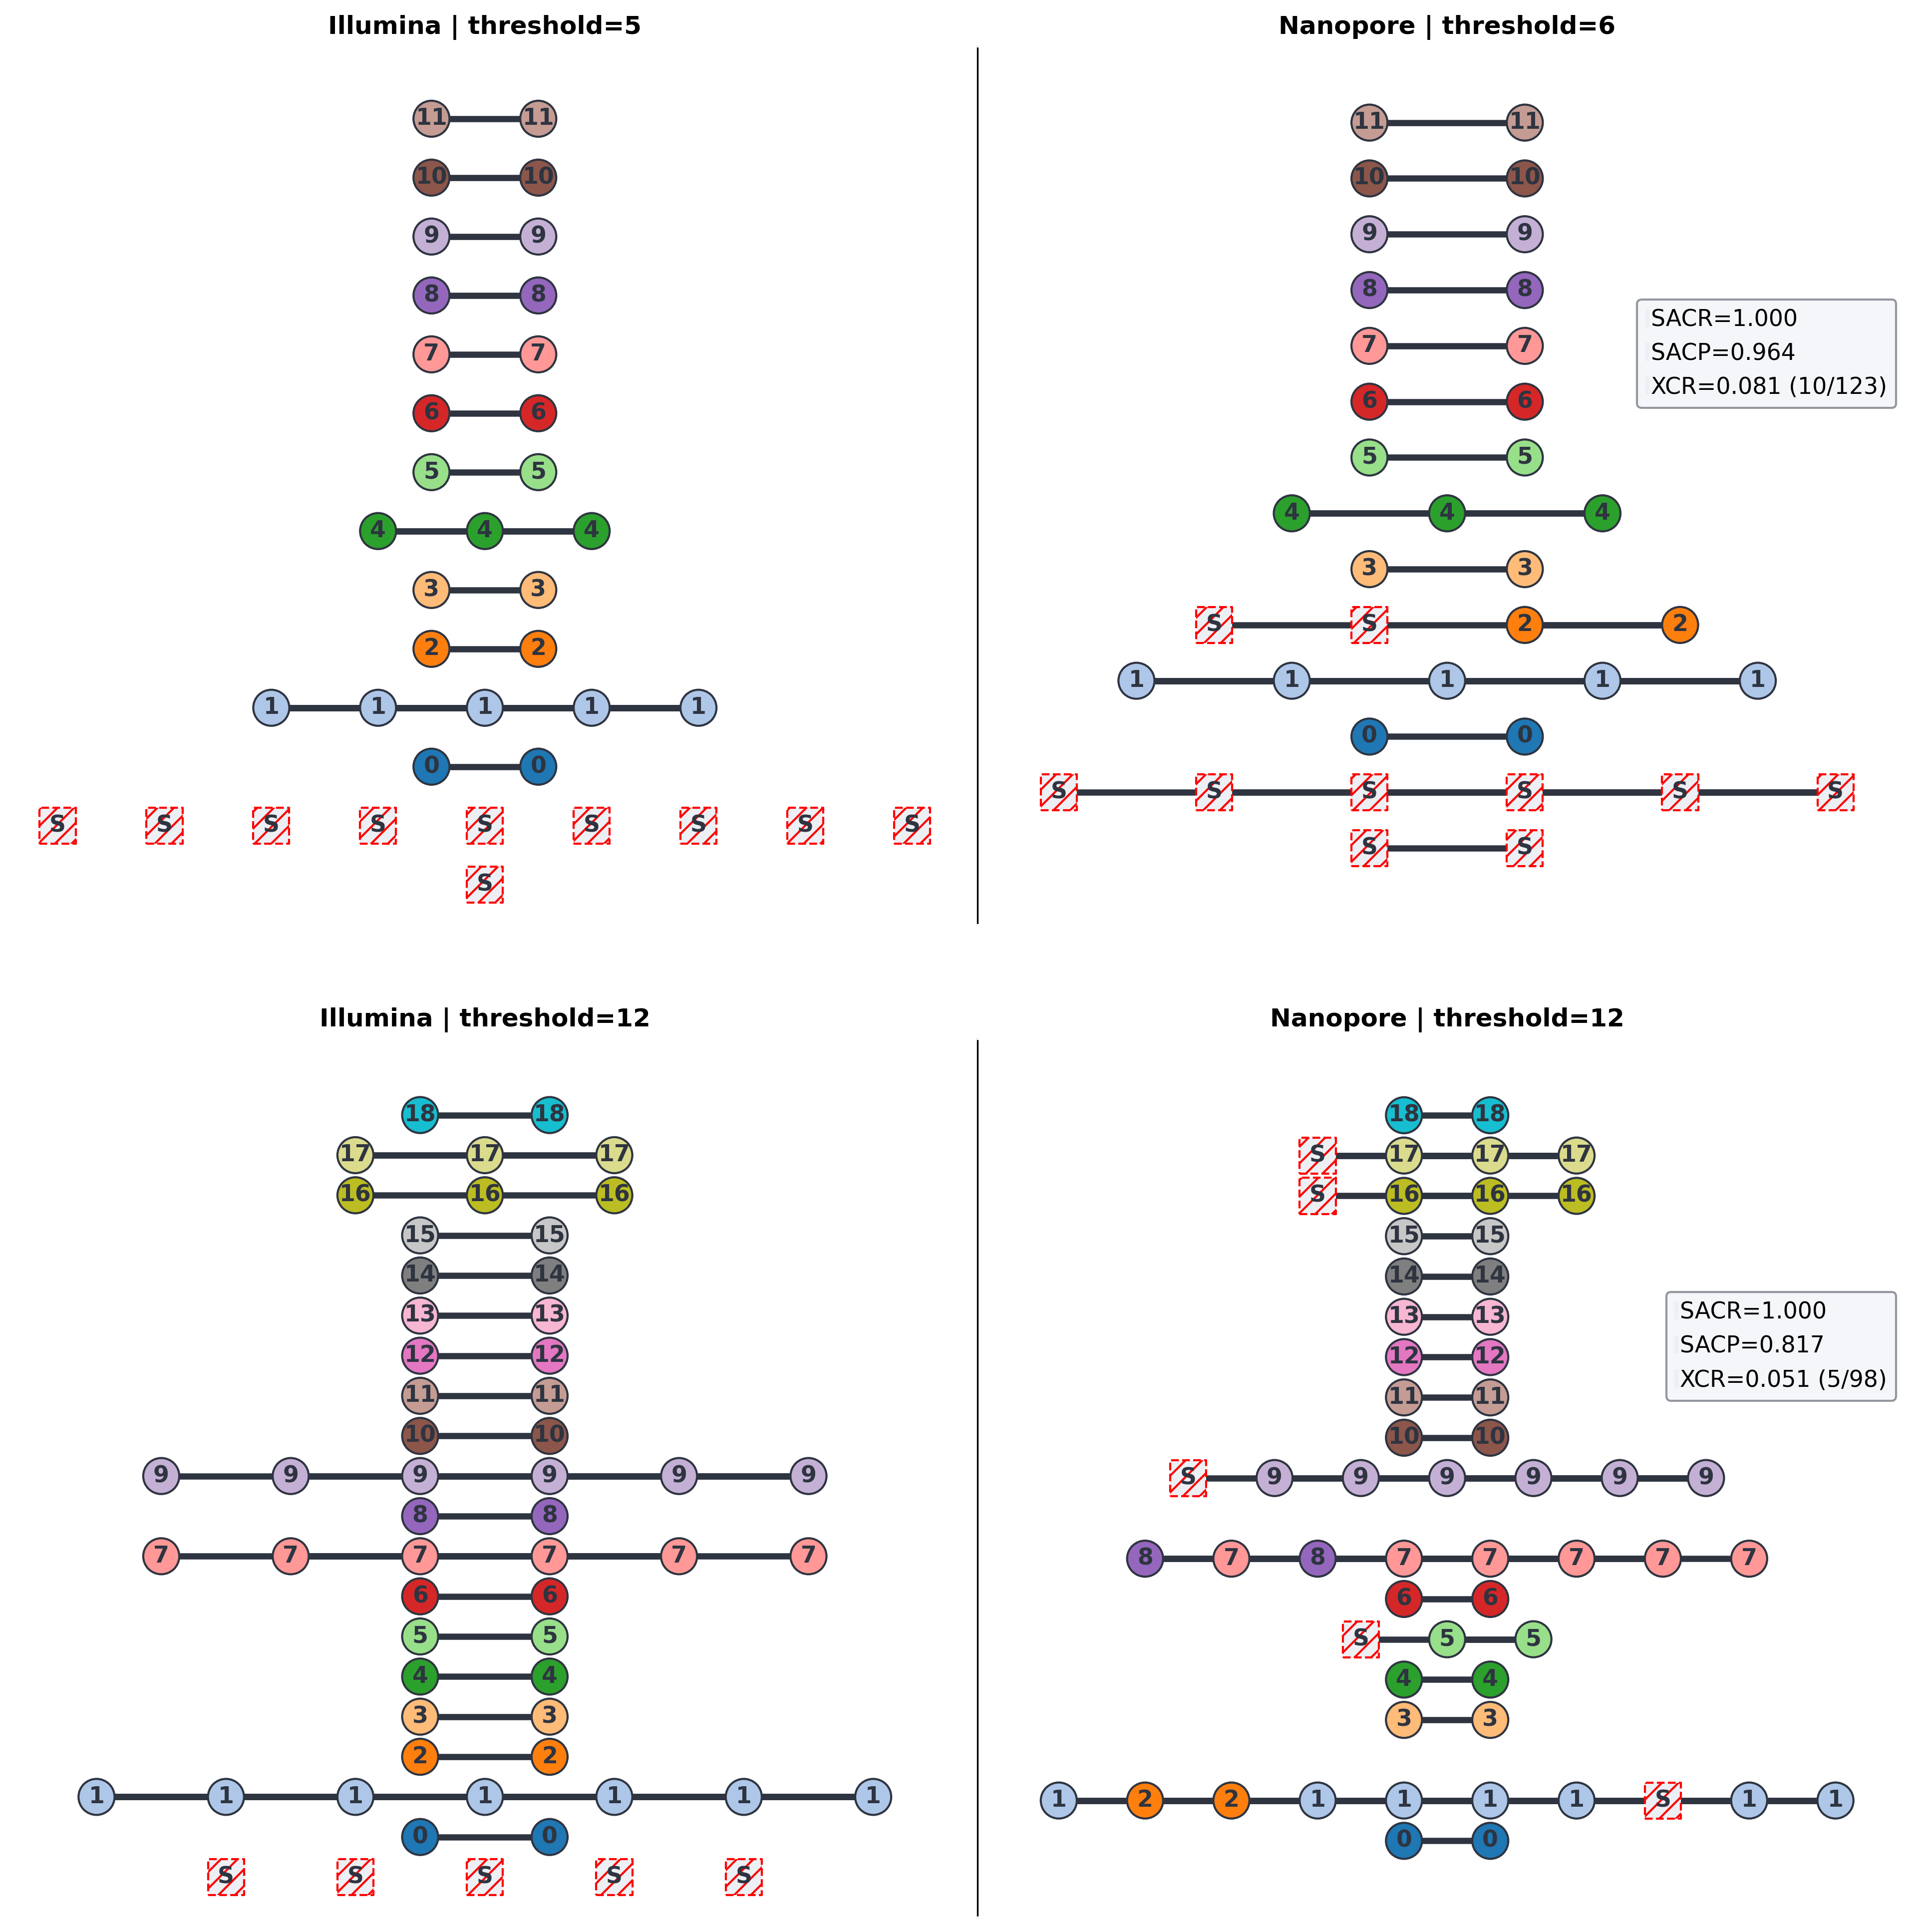

In [11]:
bcftools_dir = Path("/Users/michaelhall/Projects/head_to_head_pipeline/analysis/baseline_variants/truth_eval")
bcftools_matrix = bcftools_dir / "bcftools-q85K90x20s1V1e-5/bcftools.matrix.csv"
fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(13, 13),
    dpi=300,
    squeeze=False
)
for r, t in enumerate(thresholds):
# for t in [0]:
    illumina_mtx = load_matrix("compass.matrix.csv", name="illumina")
    G_illumina = matrix_to_graph(illumina_mtx, threshold=t, include_singletons=True)
    
    ont_mtx = load_matrix(bcftools_matrix, name="nanopore")
    G_ont = matrix_to_graph(
        ont_mtx, threshold=ont_thresholds[t], include_singletons=True
    )

    assert len(G_illumina.nodes) == len(G_ont.nodes)

    G = matrix_to_graph(illumina_mtx, threshold=t, include_singletons=True)


    node_size = 300
    edge_width = 3
    lw = 1
    font_size = 11
    fw = "bold"
    title_fontdict = dict(fontsize=12, fontweight="bold")
    align = "horizontal"
    black = "#2e3440"
    white = "#eceff4"
    red = "red"
    fc = black
    edge_colour = black
    singleton_label = "S"
    singleton_id = -1
    singleton_node_colour = white
    singleton_line_colour = red
    singleton_lw = 3
    singleton_shape = "s"  # square
    singleton_hatch = "///"
    singleton_ls = "--"
    node_shape = "o"  # circle
    colour_idx = -1
    subset_key = "cluster_id"
    node_colour_key = "node_colour"
    label_key = "label"

    node_colours = dict()
    cluster_id = dict()
    cluster_labels = dict()

    for cluster in nx.connected_components(G):
        if len(cluster) == 1:
            colour = singleton_node_colour
        else:
            colour_idx += 1
            colour = PALETTE[colour_idx]
        for v in cluster:
            node_colours[v] = colour
            if colour == singleton_node_colour:
                cluster_id[v] = singleton_id
                cluster_labels[v] = singleton_label
            else:
                cluster_id[v] = colour_idx
                cluster_labels[v] = str(colour_idx)

    max_cluster_id = colour_idx + 1

    for k, v in cluster_id.items():
        if v == singleton_id:
            cluster_id[k] = max_cluster_id

#     singleton_id = max_cluster_id

    nx.set_node_attributes(G, node_colours, node_colour_key)
    nx.set_node_attributes(G, cluster_id, subset_key)
    nx.set_node_attributes(G, cluster_labels, label_key)

    # remove singletons
#     G.remove_nodes_from(list(nx.isolates(G)))

    # add Illumina clustering plot
    ax = axes[r][0]
#     pos = nx.multipartite_layout(G, subset_key=subset_key, align=align)
#     cols = [d[node_colour_key] for v, d in G.nodes(data=True)]
#     labs = {v: d[label_key] for v, d in G.nodes(data=True)}

#     nx.draw(
#         G,
#         pos=pos,
#         ax=ax,
#         node_color=cols,
#         font_size=font_size,
#         font_color=fc,
#         labels=labs,
#         edgecolors=edge_colour,
#         font_weight=fw,
#         node_size=node_size,
#         width=edge_width,
#     )

    ax.set_title(f"Illumina | threshold={t}", fontdict=title_fontdict)

    M = ont_mtx
    T = ont_thresholds
    tool = "bcftools"
    ax = axes[r][1]
    tool_t = T[t]
    H = matrix_to_graph(M, threshold=tool_t, include_singletons=True)
    xcr_data = XCR(G_illumina.copy(), H.copy())

    nx.set_node_attributes(H, node_colours, node_colour_key)
    nx.set_node_attributes(H, cluster_id, subset_key)
    nx.set_node_attributes(H, cluster_labels, label_key)

    # remove singletons that were also singletons in Illumina
    singletons_on_both = set()
    for v in list(nx.isolates(H)):
        if node_colours[v] == singleton_node_colour:  # is also singleton in Illumina
            H.remove_node(v)
            singletons_on_both.add(v)
        else:  # is not singleton in Illumina
            H.nodes[v][subset_key] = singleton_id
            
    # add clustered singletons back to Illumina graph and set their ID
    n = 10
    count = 0
    new_id = singleton_id + 1
    to_change = []
    for v in list(nx.isolates(G)):
        if v in singletons_on_both:
            G.remove_node(v)
            continue
        count += 1
        if count >= n:
            G.nodes[v][subset_key] = singleton_id - 1
        else:
            G.nodes[v][subset_key] = singleton_id
        
        
    for v in to_change:
        G.nodes[v][subset_key] = new_id
        for u in connected_components(G, v):
            G.nodes[u][subset_key] = new_id
            
            
    # draw Illumina clusters
    ax = axes[r][0]
    pos = nx.multipartite_layout(G, subset_key=subset_key, align=align)
    labs = {v: d[label_key] for v, d in G.nodes(data=True)}

    for shape in [singleton_shape, node_shape]:
        if shape == singleton_shape:
            vs = [k for k, v in labs.items() if v == singleton_label]
        else:
            vs = [k for k, v in labs.items() if v != singleton_label]
        ps = {v: pos[v] for v in vs}
        cols = [G.nodes[v][node_colour_key] for v in vs]

        node_ax = nx.draw_networkx_nodes(
            G,
            pos=ps,
            nodelist=vs,
            node_color=cols,
            node_shape=shape,
            edgecolors=edge_colour,
            ax=ax,
            node_size=node_size,
        )
        if shape == singleton_shape:
            node_ax.set_hatch(singleton_hatch)
            node_ax.set_edgecolor(singleton_line_colour)
            node_ax.set_linestyle(singleton_ls)

    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colour, width=edge_width)
    nx.draw_networkx_labels(
        G, pos, labels=labs, ax=ax, font_size=font_size, font_weight=fw, font_color=fc
    )

    # give nodes that were singleton on Illumina, but now clustered
    # in Nanopore the cluster ID of their nanopore cluster
    clusters = nx.connected_components(H)
    for c in clusters:
        ids = {H.nodes[v][subset_key] for v in c}
        if len(ids) == 1:
            continue
        sorted_ids = sorted(ids)
        new_id = sorted_ids[0]

        for v in c:
            H.nodes[v][subset_key] = new_id

    # if there are more than n nodes in the singletons line, split over more lines
    count = 0
    new_id = singleton_id + 1
    to_change = []
    for v, d in H.nodes(data=True):
        if d[subset_key] == singleton_id:
            count += 1
            if count >= n:
                to_change.append(v)

    for v in to_change:
        H.nodes[v][subset_key] = new_id
        for u in connected_components(H, v):
            H.nodes[u][subset_key] = new_id
     
    counter = 0
    for cc in nx.connected_components(H):
        if all(cluster_labels[v] == singleton_label for v in cc):
            for v in cc:
                H.nodes[v][subset_key] = singleton_id-counter
            counter += 1

    ax = axes[r][1]
    pos = nx.multipartite_layout(H, subset_key=subset_key, align=align)
    labs = {v: d[label_key] for v, d in H.nodes(data=True)}
    sacp, sacr = SACP_AND_SACR(
        matrix_to_graph(illumina_mtx, threshold=t, include_singletons=False),
        matrix_to_graph(M, threshold=tool_t, include_singletons=False),
    )

    for shape in [singleton_shape, node_shape]:
        if shape == singleton_shape:
            vs = [k for k, v in labs.items() if v == singleton_label]
        else:
            vs = [k for k, v in labs.items() if v != singleton_label]
        ps = {v: pos[v] for v in vs}
        cols = [H.nodes[v][node_colour_key] for v in vs]

        node_ax = nx.draw_networkx_nodes(
            H,
            pos=ps,
            nodelist=vs,
            node_color=cols,
            node_shape=shape,
            edgecolors=edge_colour,
            ax=ax,
            node_size=node_size,
        )
        if shape == singleton_shape:
            node_ax.set_hatch(singleton_hatch)
            node_ax.set_edgecolor(singleton_line_colour)
            node_ax.set_linestyle(singleton_ls)

    nx.draw_networkx_edges(H, pos, ax=ax, edge_color=edge_colour, width=edge_width)
    nx.draw_networkx_labels(
        H, pos, labels=labs, ax=ax, font_size=font_size, font_weight=fw, font_color=fc
    )

    fs = font_size

    c = mpatches.Circle((1, 1), 0.0001, color=white)
    metrics = [
        f"SACR={sacr:.3f}",
        f"SACP={sacp:.3f}",
        f"XCR={xcr_data[0]:.3f} ({xcr_data[1]}/{xcr_data[2]})",
    ]

    clustering_metrics.append([t, tool_t, sacr, sacp, *xcr_data])

    location = dict(loc="center right", bbox_to_anchor=(0.99, 0.65))

    ax.legend(
        [c] * len(metrics),
        metrics,
        facecolor=white,
        handlelength=0.1,
        handletextpad=0.1,
        fontsize=fs,
        framealpha=0.5,
        edgecolor=black,
        frameon=True,
        **location,
    )

    ax.set_title(f"Nanopore | threshold={tool_t}", fontdict=title_fontdict)

    for i, ax in enumerate(axes.flatten()):
        fc = ax.get_facecolor()
        if i % 2:
            ax.spines["left"].set_color("black")
        else:
            ax.spines["left"].set_color(fc)
            
        ax.spines["top"].set_color(fc)
        ax.spines["right"].set_color(fc)
        ax.spines["bottom"].set_color(fc)

#     plt.tight_layout(h_pad=4.0)
#     fig.savefig(bcftools_matrix.parent / f"cluster_{t}.png")

plt.tight_layout(h_pad=4.0)
fig.savefig("clusters.png")
# fig.savefig("/Users/michaelhall/Projects/head_to_head_pipeline/docs/paper_figures/fig4.svg")

In [7]:
df = pd.DataFrame(
    clustering_metrics,
    columns=[
        "illumina_threshold",
        "nanopore_threshold",
        "SACR",
        "SACP",
        "XCR",
        "clustered_singletons",
        "expected_singletons",
    ],
)
# df.to_csv(snakemake.output[0], index=False)

In [8]:
from itertools import chain
compass_mtx = load_matrix("compass.matrix.csv", name="illumina")
samples = set(np.unique(np.array(list(chain.from_iterable(compass_mtx.index)))))

In [9]:
M = compass_mtx
# G = matrix_to_graph(M, threshold=t, include_singletons=True)
N = load_matrix(bcftools_matrix, name="bcftools")
# H = matrix_to_graph(N, threshold=)

In [17]:
data = []
distances = [5, 12]
ont_dists = list(range(2, 15))
# print("Dist.\tThresh.\tSize\tPPV\tTPR")
for d in distances:
    T = matrix_to_graph(M, threshold=d)
    true_clusters = [c for c in nx.connected_components(T)]
    true_singletons = samples - set(T.nodes)
    for t in ont_dists:
        g = matrix_to_graph(N, threshold=t)
        num_test_clusters = len(list(nx.connected_components(g)))
        test_singletons = samples - set(g.nodes)
        xcr = excess_clustering_rate(true_singletons, test_singletons)
        sacp, sacr = SACP_AND_SACR(
            matrix_to_graph(M, threshold=d, include_singletons=False),
            matrix_to_graph(N, threshold=t, include_singletons=False),
        )
        data.append((d, t, sacr, sacp, 1-xcr))
#             print(f"{d}\t{t}\t{len(cluster)}\t{np.mean(cluster_ppv):.2f}\t{np.mean(cluster_tpr):.2f}")

In [18]:
df = pd.DataFrame(
    data, 
    columns=["distance", "threshold", "SACR", "SACP", "1-XCR"]
).melt(id_vars=["distance", "threshold"], var_name="metric")

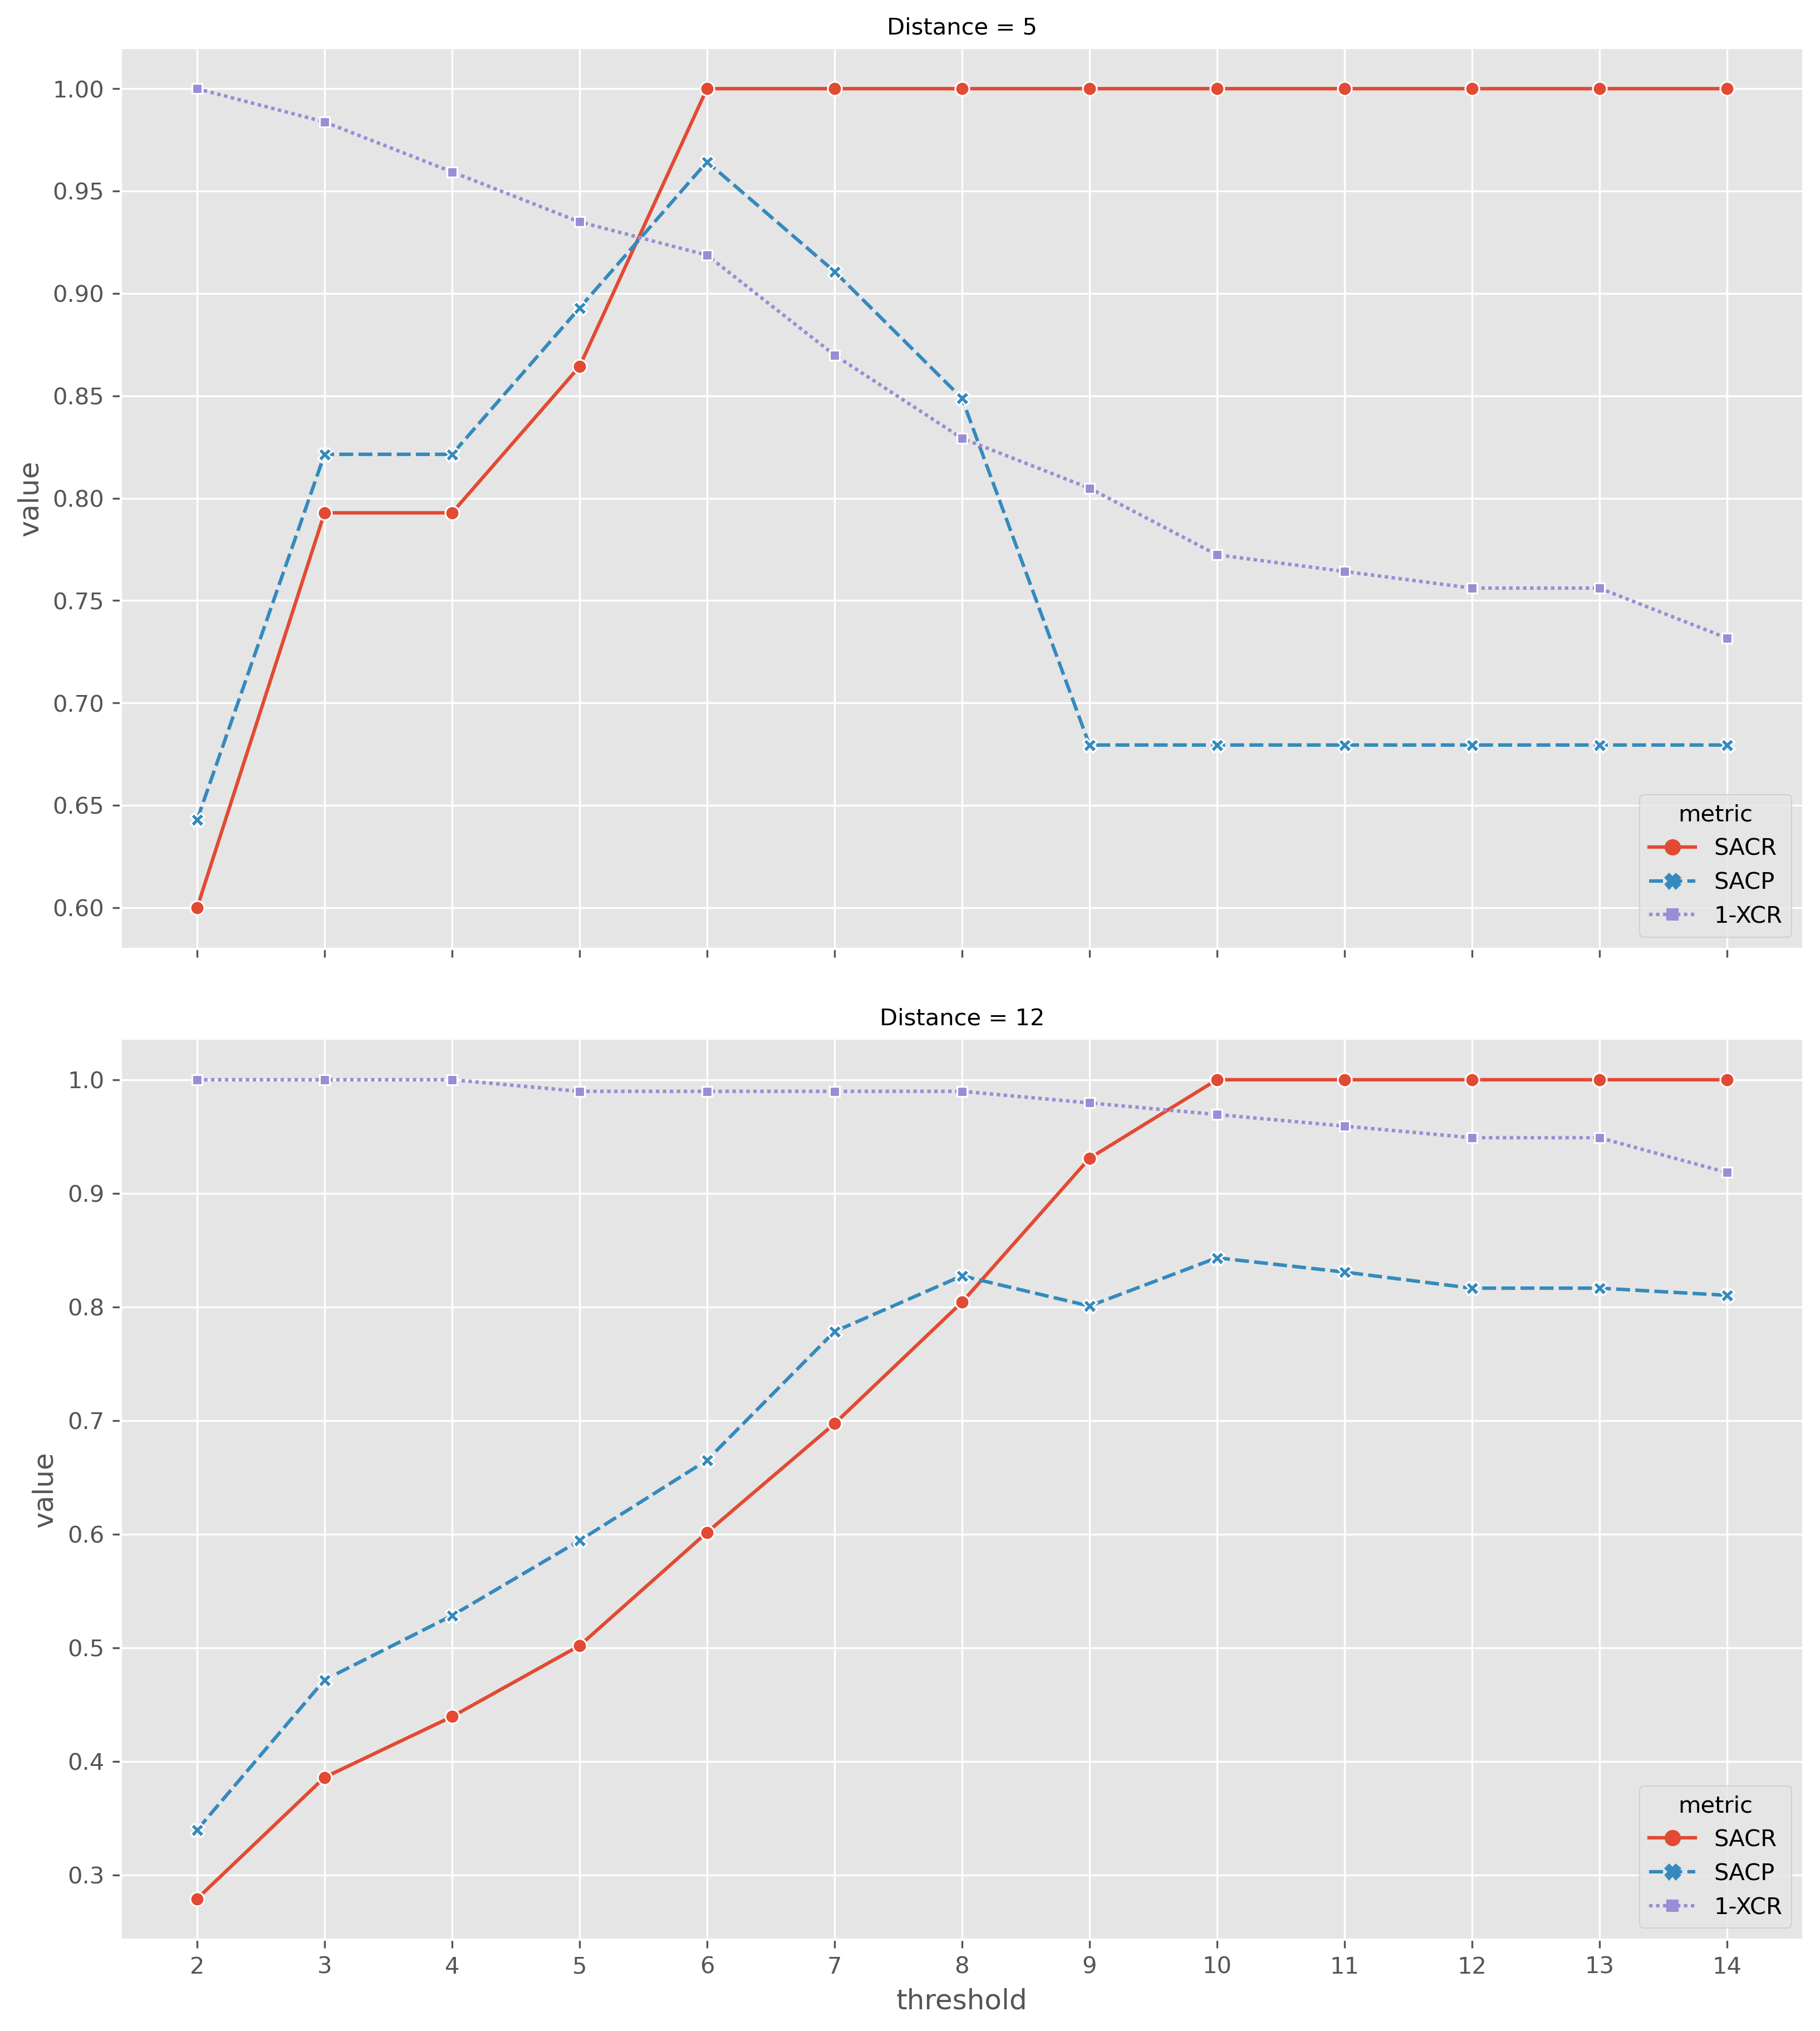

In [28]:
plt.style.use("ggplot")
fig, axes = plt.subplots(nrows=len(distances), figsize=(13, 15), dpi=300, sharex=True)

for ax, dist, t in zip(axes.flatten(), distances, ont_dists):
    subdata = df.query("distance == @dist")
    sns.lineplot(data=subdata, x="threshold", y="value", hue="metric", ax=ax, style="metric", markers=True)
    ax.set_xticks(ont_dists)
    ax.set_xticklabels(ont_dists)
    ax.set_title(f"Distance = {dist}", fontdict=dict(size=10))
# plt.tight_layout()
fig.subplots_adjust(hspace=0.1)
#     print(subdata.query("threshold == @t").groupby(["metric"])["value"].describe())

In [118]:
fig.savefig(bcftools_matrix.parent / "cluster_threshold_sweep.png")

In [120]:
df.query("distance==5 and threshold==6")

,distance,threshold,metric,value
36,5,6,SACR,1.000000
96,5,6,SACP,0.964286
156,5,6,1-XCR,0.918699


In [35]:
pos

{'17_616156': array([-0.05215827, -0.87769784]),
 '17_616026': array([ 0.05215827, -0.87769784]),
 'R26791': array([-0.46942446, -0.77338129]),
 'R20574': array([-0.36510791, -0.77338129]),
 'R20260': array([-0.26079137, -0.77338129]),
 'R28182': array([-0.15647482, -0.77338129]),
 'R27937': array([-0.05215827, -0.77338129]),
 'R27725': array([ 0.05215827, -0.77338129]),
 'R22601': array([ 0.15647482, -0.77338129]),
 'R21408': array([ 0.26079137, -0.77338129]),
 'R18043': array([ 0.36510791, -0.77338129]),
 'R18040': array([ 0.46942446, -0.77338129]),
 'R30396': array([-0.05215827, -0.5647482 ]),
 'R20896': array([ 0.05215827, -0.5647482 ]),
 'R21770': array([-0.05215827, -0.46043165]),
 'R20983': array([ 0.05215827, -0.46043165]),
 'R32929': array([-0.10431655, -0.35611511]),
 'R28980': array([ 0.        , -0.35611511]),
 'R23146': array([ 0.10431655, -0.35611511]),
 'R29598': array([-0.05215827, -0.25179856]),
 'R24100': array([ 0.05215827, -0.25179856]),
 'R30234': array([-0.3651079